
Basic Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

Statistical Summary:

         RowNumber    CustomerId   CreditScore           

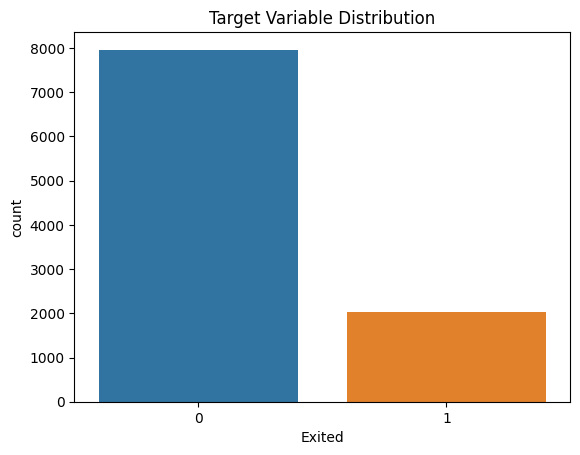


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1593
           1       0.85      0.84      0.85      1593

    accuracy                           0.85      3186
   macro avg       0.85      0.85      0.85      3186
weighted avg       0.85      0.85      0.85      3186



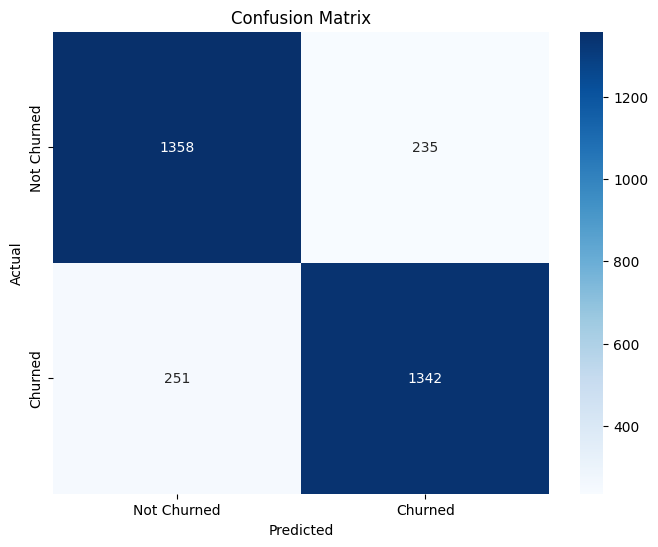

ROC-AUC Score: 0.9268
Weighted F1 Score: 0.8475


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Step 1: Load the Dataset
# Replace 'your_dataset_path.csv' with the path to your dataset.
data_path = "/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv"
data = pd.read_csv(data_path)

# Step 2: Exploratory Data Analysis (EDA)
# Check the structure and summary of the dataset
print("\nBasic Info:\n")
data.info()

print("\nStatistical Summary:\n")
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Check target variable distribution
sns.countplot(x='Exited', data=data)
plt.title('Target Variable Distribution')
plt.show()

# Step 3: Preprocessing
# Drop irrelevant columns
irrelevant_cols = ['RowNumber', 'CustomerId', 'Surname']
data = data.drop(columns=irrelevant_cols)

# Encode categorical variables
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])  # Encode Gender

data = pd.get_dummies(data, columns=['Geography'], drop_first=True)  # One-hot encode Geography

# Split features and target
X = data.drop('Exited', axis=1)
y = data['Exited']

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Advanced Stacking Ensemble Setup
# Define base models with tuned parameters
base_models = [
    ('log_reg', LogisticRegression(max_iter=1000, C=0.5, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    ('lgbm', LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42))
]

# Define meta-model
meta_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Initialize Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Train the model
stacking_clf.fit(X_train, y_train)

# Step 5: Evaluation
# Make predictions
y_pred = stacking_clf.predict(X_test)
y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# Feature Importance (if supported by meta-model)
if hasattr(meta_model, 'feature_importances_'):
    feature_importance = meta_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.show()
